# APS 2 - Transferência de Calor e Mecânica dos Sólidos

## Enunciado

Considere uma aleta de seção transversal circular e constante, com temperatura fixa na base e exposta ao ambiente em todas as outras superfícies. Podemos esboçar as entradas e saídas de energia em um volume de controle definido ao redor de uma seção como indica a Fig.1.

<img src="./enunciado.jpeg" />

- $q_x$ taxa de transferência de calor por condução em $x$.
- $q_{x + dx}$ taxa de transferência de calor por condução em $x + dx$.
- $dq_{conv}$ taxa de transferência de calor por convecção através da área superficial do elemento diferencial.

Substituindo as equações de taxa $q_x$, $q_{x + dx}$ e $dq_{conv}$ podemos obter a forma geral da equação da energia para uma 
superfície estendida, em regime transiente como: 

<img src="./eq.jpeg">

## Roteiro

- Aplique os conceitos do método das diferenças finitas na equação diferencial do problema para definir uma equação de diferença algébrica associada aos nós da aleta. Considere para a segunda derivada da temperatura no espaço uma equação de diferença finita centrada e para a primeira derivada no tempo da temperatura uma equação de diferença progressiva. Apresente o desenvolvimento das equações.

- Apresente um gráfico ($Temperatura \times posição$) após obter o regime permanente. Use uma tolerância de $tol = 1 \cdot10^{-10}$. Considere que a aleta, de comprimento $L = 300mm$ , densidade de $2700 kg/m^3$ , condutividade térmica de $180 W/(mK)$ e calor específico $896 J/(kg K)$, tem a temperatura especificada na extremidade de $T(L) = 25 °C$. A aleta está em contato com uma base a $𝑇_b = 100℃$ em um ambiente a $𝑇_{\infty} = 50 °C$ e $h = 50W/m^2K$. Para a condição de estabilidade do procedimento numérico use $\Delta t \leq \frac{\Delta x^2}{\alpha \cdot \left(\frac{h P \Delta x^2}{k A_{tr}} + 2 \right) }$.

- Para validar os resultados obtidos com o software desenvolvido, apresente um gráfico ($Temperatura \times posição$) para o comportamento analítico da temperatura na aleta usando as mesmas condições definidas no item anterior.

### Bibliotecas necessárias

In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

### Parâmetros e constantes iniciais fornecidas

In [2]:
# Tolerância
tol = 1e-10

# Comprimento da aleta (m)
L = 0.3

# Densidade (kg / m^3)
dens = 2700

# Condutividade térmica (W/m.K)
k = 180

# Calor específico (J/kg.K)
c = 896

# Temperatura na extremidade (K)
T_L = 50 + 273

# Temperatura da base (K)
T_b = 100 + 273

# Temperatura do ambiente (K)
T_amb = 50 + 273

# Constante de convecção (W / K.m^2)
h = 50

# Difusividade
alpha = k / (dens * c)

### Parâmetros e constantes definidos para um caso

In [3]:
# Raio da aleta (m)
r = 12e-3

# Delta x (0.1 mm)
dx = 1e-4

# Tempo total (5 min)
t_total = 1 * 60

#### Valor máximo para $\Delta t$

In [4]:
# Área transversal
A_tr = pi * (r**2)

# Perímetro
P = 2 * pi * r

# dt = (dx**2) / (alpha * (2 + (h * P * (dx**2))/(k * A_tr)))
dt = 0.01
print(f"Para condição de estabilidade: dt < {dt}")

Para condição de estabilidade: dt < 0.01


### Começando a brincadeira

In [5]:
time_list = np.arange(0, t_total + dt, dt)
lgth_list = np.arange(0, L + dx, dx)
temp_list = list()

In [6]:
print(lgth_list, len(lgth_list))
print(time_list, len(time_list))

[0.000e+00 1.000e-04 2.000e-04 ... 2.998e-01 2.999e-01 3.000e-01] 3001
[0.000e+00 1.000e-02 2.000e-02 ... 5.998e+01 5.999e+01 6.000e+01] 6001


In [7]:
for x in lgth_list:
    if (x == 0):
        temp_list.append(T_b)
    elif (x == L):
        temp_list.append(T_L)
    else:
        temp_list.append(T_b)

In [8]:
print(len(temp_list), temp_list)

3001 [373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373,

In [9]:
for t in range(len(time_list)):
    new_temps = [T_b]
    for i in range(1, len(lgth_list) - 1):
        coef_1 = (temp_list[i + 1] - (2 * temp_list[i]) + temp_list[i - 1]) / (dx**2)
        coef_2 = (h * P * (temp_list[i] - T_amb)) / (k * A_tr)
        new_temp = temp_list[i] + alpha * dt * (coef_1 - coef_2)
        new_temps.append(new_temp)
    temp_list = new_temps
    temp_list.append(T_L)

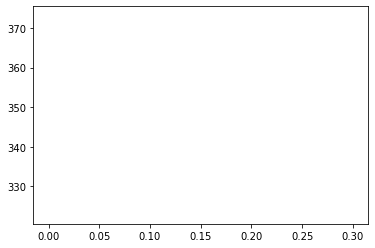

In [10]:
plt.plot(lgth_list, temp_list, 'r')
plt.show()

In [ ]:
print(len(temp_list), temp_list)